# Data Dimensionality Reduction
Comparar os 4 métodos de redução de dimensões (PCA, SVD, NMF e Autoencoder) em relação ao modelo sem nenhum tipo de redução.  
Para tornar o exercício mais interessante, será avaliado não só os 4 algoritmos de redução de dimensão, mas também vários modelos de classificação.  
O objetivo final é termos a melhor opção entre o modelo de classificação e de redução (se for o caso).  

### Base de dados - SK-Learn Breast Cancer

Para o exercício será utilizado o dataset do sklearn **breast cancer** (UCI ML Breast Cancer) no que contém informações sobre câncer de mama e a classificação se é benigno ou maligno.  
Maiores detalhes sobre o dataset disponível em  
https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer


***Fonte original do dataset***  
The copy of UCI ML Breast Cancer Wisconsin (Diagnostic) dataset is downloaded from:  
https://goo.gl/U2Uwz2


### Instalando as bibliotecas necessárias
Esta etapa pode ser pulada se o ambiente já estiver configurado com as bibliotecas  
*A instalação do  tensorflow foi recomendada pelo site do KERAS embora não utilizemos no exercício*

!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install -U scikit-learn
!pip install tensorflow #keras
!pip install keras #keras

## Importando o Dataset
O conjunto de dados utilizado contém possui em seu target uma classificação binária do câncer em 'malignant', 'benign' (maligno ou benigno).  
O objetivo, é criar um classificador que ao avaliar suas 30 features possa determinar o tipo do cancer.


In [6]:
#importando o conjunto de dados
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()

### Exibindo as Features e targets

In [7]:

print('Target:', data.target_names, '\n')
print('Features:',data.feature_names)

Target: ['malignant' 'benign'] 

Features: ['mean radius' 'mean texture' 'mean perimeter' 'mean area'
 'mean smoothness' 'mean compactness' 'mean concavity'
 'mean concave points' 'mean symmetry' 'mean fractal dimension'
 'radius error' 'texture error' 'perimeter error' 'area error'
 'smoothness error' 'compactness error' 'concavity error'
 'concave points error' 'symmetry error' 'fractal dimension error'
 'worst radius' 'worst texture' 'worst perimeter' 'worst area'
 'worst smoothness' 'worst compactness' 'worst concavity'
 'worst concave points' 'worst symmetry' 'worst fractal dimension']


### Importando as demais bibliotecas utilizadas

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as snb
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn import model_selection 

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.sparse import csr_matrix

import warnings
warnings.filterwarnings("ignore")


### Separando os dados em treino e teste

Para o exemplo utilizaremos uma base de tete de 30% do conjunto de dados.

In [9]:
random_state = 42
#Carregndo novamente já seprando os dados
X, y = load_breast_cancer(return_X_y=True)

#separando em treino e teste com 40% para o teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state)

### Rodando 3 modelos para avaliar os resultados

Utilizar o GridSearch para testar um conjunto de hipoteses de parametros. O objetivo é descobrir a melhor combinação entre eles e maximizar o resultado da classificação para os 3 modelos escolhidos.

In [10]:
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

params_gb = {
    'var_smoothing': np.logspace(0,-9, num=100)
}

params_svc = {
    'C': [0.1, 1, 10, 100, 1000], 
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf', 'poly', 'sigmoid']
}

params_rf = {
    'random_state': [None, 0, 1, 2, 3, 42],
    'max_depth': [None, 1, 2, 3, 4, 15, 20],
    'n_estimators': [5, 10, 100, 150, 200], 
    'max_features': ['auto', 'sqrt', 'log2', 1, 2, 3],
    'criterion': ['gini', 'entropy'],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 3, 4, 5]
}

gsc_rf = GridSearchCV(estimator=RandomForestClassifier(),param_grid=params_rf ,cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_result_rf = gsc_rf.fit(X_train, y_train)

gsc_gb = GridSearchCV(estimator=GaussianNB(),param_grid=params_gb ,cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_result_gb = gsc_gb.fit(X_train, y_train)

gsc_svc = GridSearchCV(estimator=SVC(),param_grid=params_svc ,cv=5, scoring='accuracy', verbose=0, n_jobs=-1)
grid_result_svc = gsc_gb.fit(X_train, y_train)



In [14]:
print('RF:', gsc_rf.best_score_)
print('GB:', gsc_gb.best_score_)
print('SVS:', grid_result_svc.best_score_)

RF: 0.9699050632911392
GB: 0.9421835443037976
SVS: 0.9421835443037976


### Avaliando o resultado do GridSearch
Com os o tunning dos hyperparametros, o melhor algoritmo foi o RandomForest.  
Aplicar o modelo com dados de teste para seguir com os resultados

In [15]:

best_params = grid_result_rf.best_params_
classifier = RandomForestClassifier(max_depth=best_params["max_depth"], 
                                    random_state=best_params["random_state"],
                                    n_estimators = best_params["n_estimators"], 
                                    max_features = best_params["max_features"],
                                    criterion=best_params["criterion"], 
                                    min_samples_split=best_params["min_samples_split"], 
                                    min_samples_leaf = best_params["min_samples_leaf"])
print("RandomForestClassifier GIRD")
for k, v in best_params.items():
    print(' ', k, ': ',  v,)

RandomForestClassifier GIRD
  criterion :  entropy
  max_depth :  None
  max_features :  auto
  min_samples_leaf :  1
  min_samples_split :  4
  n_estimators :  10
  random_state :  None



              precision    recall  f1-score   support

     Maligno       0.98      0.94      0.96        63
     Benigno       0.96      0.99      0.98       108

    accuracy                           0.97       171
   macro avg       0.97      0.96      0.97       171
weighted avg       0.97      0.97      0.97       171



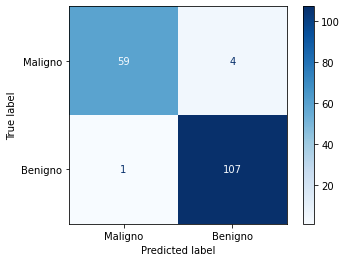

In [16]:
results = []
model = classifier.fit(X_train, y_train)
y_pred = model.predict(X_test) # avaliando o melhor estimador


print("")
print(classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno']))
report = classification_report(y_test, y_pred, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('Modelo', report))
plot_confusion_matrix(classifier, X_test, y_test, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Avaliando as features do modelo quanto a sua importancia

mean radius: 0.06749
mean texture: 0.01010
mean perimeter: 0.04946
mean area: 0.01545
mean smoothness: 0.00493
mean compactness: 0.01370
mean concavity: 0.02343
mean concave points: 0.05138
mean symmetry: 0.00456
mean fractal dimension: 0.00181
radius error: 0.00743
texture error: 0.01039
perimeter error: 0.01505
area error: 0.01698
smoothness error: 0.00420
compactness error: 0.00199
concavity error: 0.00348
concave points error: 0.00277
symmetry error: 0.00671
fractal dimension error: 0.01249
worst radius: 0.15492
worst texture: 0.01203
worst perimeter: 0.08237
worst area: 0.08998
worst smoothness: 0.01045
worst compactness: 0.00530
worst concavity: 0.05461
worst concave points: 0.26050
worst symmetry: 0.00402
worst fractal dimension: 0.00203


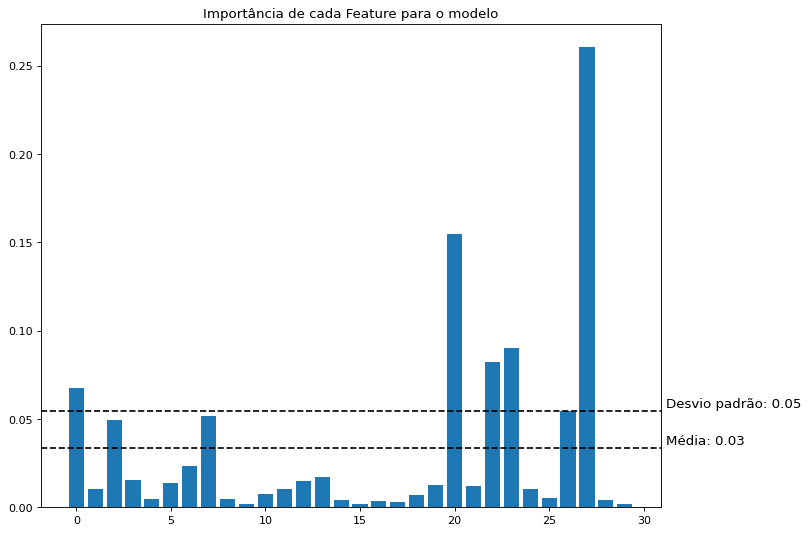

In [18]:
from matplotlib.pyplot import figure
figure(figsize=(10, 8), dpi=80)

def avaliar_features(modelo):
    model.fit(X_train, y_train)
    importance = model.feature_importances_
    colunas = data.feature_names
    values = []
    # summarize feature importance
    for i,v in enumerate(importance):
        print('%s: %.5f' % (colunas[i],v))
        values.append(v)

    # plot feature importance
    plt.bar([x for x in range(len(importance))], importance)
    std_var = np.std(values)
    media = np.mean(values)

    
    plt.axhline(y= media, linestyle="--", color='k')
    plt.annotate('%s: %.2f' % ('Média',media), xy=(30, media), xycoords='data', xytext=(20, 4), textcoords='offset points', fontsize=12, color='k')
    
    plt.axhline(y= std_var, linestyle="--", color='k')
    plt.annotate('%s: %.2f' % ('Desvio padrão',std_var), xy=(30, std_var), xycoords='data', xytext=(20, 4), textcoords='offset points', fontsize=12, color='k')
   
    plt.title("Importância de cada Feature para o modelo")
    plt.show()

avaliar_features(model)

## Aplicando os algoritmos de redução de dimensões para comparar os resultados

Com base no gráfico, pecebemos que cada uma das features possui um grau diferente de relevancia para o algoritmo. Avaliar a possibilidade de diminuir a quantidade de features economizaria tempo computacional considerável.

### PCA - Principal Component Analysis

              precision    recall  f1-score   support

     Maligno       0.88      0.95      0.92        80
     Benigno       0.97      0.93      0.95       148

    accuracy                           0.94       228
   macro avg       0.93      0.94      0.93       228
weighted avg       0.94      0.94      0.94       228



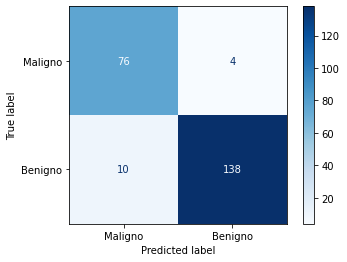

In [19]:
#Aplicar a redução de dimensão em X e rodar o processo novamente com os melhores parametros
from sklearn.decomposition import PCA as sklearnPCA

#escalando dados
standard_scaler = StandardScaler()
X_rescaled  = standard_scaler.fit_transform(X)
pct_components = 0.95

pca = sklearnPCA(n_components=pct_components)
X_pca = pca.fit_transform(X_rescaled)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train_pca, y_train_pca)
y_pred_pca = model.predict(X_test_pca) # avaliando o melhor estimador

report = classification_report(y_test_pca, y_pred_pca, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('PCA', report))
print(classification_report(y_test_pca, y_pred_pca, target_names=['Maligno', 'Benigno']))
plot_confusion_matrix(classifier, X_test_pca, y_test_pca, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Exibindo o gráfico de componentes necessários com base em uma variancia de 0.95%
Formato de dados antes e depois do PCA

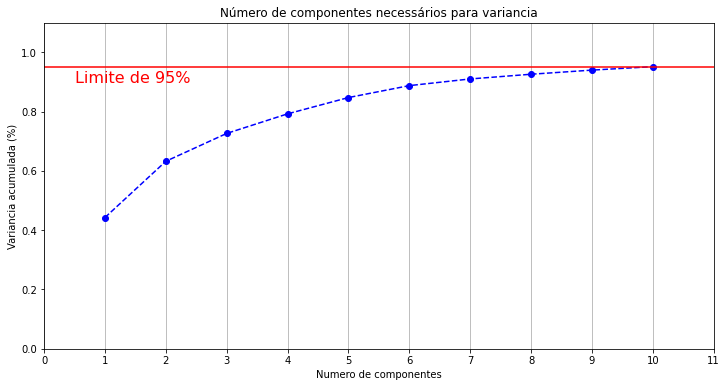

In [20]:
plt.rcParams["figure.figsize"] = (12,6)

fig, ax = plt.subplots()
xi = np.arange(1, X_pca.shape[1]+1, step=1)
yi = np.cumsum(pca.explained_variance_ratio_)

plt.ylim(0.0,1.1)
plt.plot(xi, yi, marker='o', linestyle='--', color='b')

plt.xlabel('Numero de componentes')
plt.xticks(np.arange(0, X_pca.shape[1]+2, step=1)) #mudando a escala do eixo só pra ficar mais bacana
plt.ylabel('Variancia acumulada (%)')
plt.title('Número de componentes necessários para variancia')

plt.axhline(y=pct_components, color='r', linestyle='-')
plt.text(0.5, 0.90, 'Limite de 95%', color = 'red', fontsize=16)

ax.grid(axis='x')
plt.show()

### SVD - Single Value Decomposition

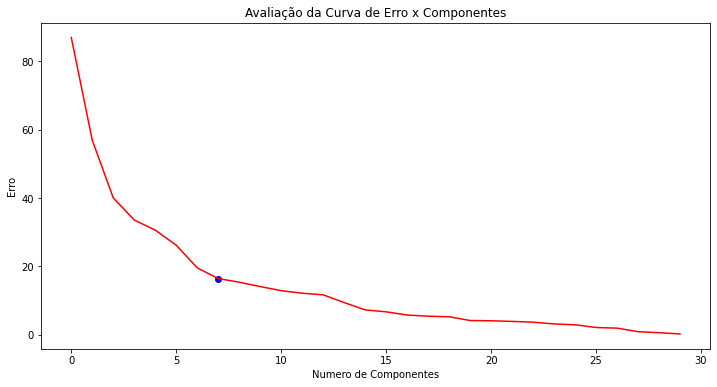

In [21]:
U, S, V = np.linalg.svd(X_rescaled)
k = 7
df = pd.DataFrame({'x_values': list(range(len(S))), 'y_values': S })
plt.rcParams["figure.figsize"] = (12,6)
plt.plot('x_values', 'y_values', data=df, color='red')
plt.scatter(k, S[k], color='blue')
plt.title("Avaliação da Curva de Erro x Componentes")
plt.xlabel("Numero de Componentes")
plt.ylabel("Erro")
plt.show()

### Avaliando a quantidade de componentes
Com a avaliação do gráfico, consideraremos 7 componentes

              precision    recall  f1-score   support

     Maligno       0.92      0.95      0.93        80
     Benigno       0.97      0.95      0.96       148

    accuracy                           0.95       228
   macro avg       0.94      0.95      0.95       228
weighted avg       0.95      0.95      0.95       228



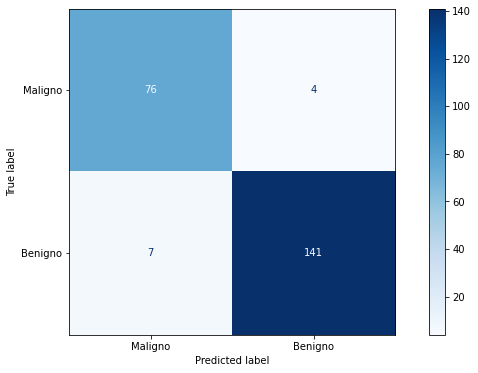

In [22]:
from sklearn.decomposition import TruncatedSVD as sklearnSVD

#normalizando os dados
standard_scaler = StandardScaler()
X_rescaled  = standard_scaler.fit_transform(X)

svd = sklearnSVD(n_components=7)
X_svd = svd.fit_transform(X_rescaled)

X_train_svd, X_test_svd, y_train_svd, y_test_svd = train_test_split(X_svd, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train_svd, y_train_svd)
y_pred_svd = model.predict(X_test_svd) # avaliando o melhor estimador

report = classification_report(y_test_svd, y_pred_svd, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('SVD', report))
print(classification_report(y_test_svd, y_pred_svd, target_names=['Maligno', 'Benigno']))
plot_confusion_matrix(classifier, X_test_svd, y_test_svd, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### NMF - Non-negative Matrix Factorization

              precision    recall  f1-score   support

     Maligno       0.97      0.96      0.97        80
     Benigno       0.98      0.99      0.98       148

    accuracy                           0.98       228
   macro avg       0.98      0.97      0.98       228
weighted avg       0.98      0.98      0.98       228



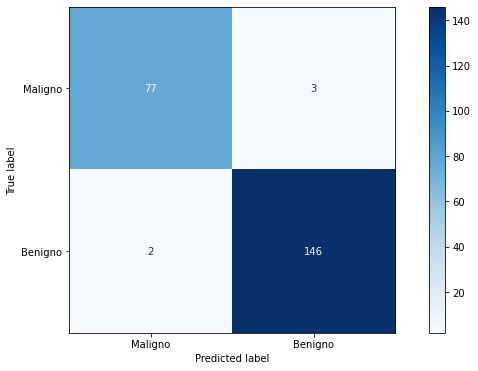

In [23]:
from sklearn.decomposition import NMF as sklearnNMF

nmf = sklearnNMF(n_components=10)

#escalando dados
minmax_scaler = MinMaxScaler()
X_rescaled  = minmax_scaler.fit_transform(X)
X_train_nmf, X_test_nmf, y_train_nmf, y_test_nmf = train_test_split(X_rescaled, y, test_size=0.4, random_state=random_state)

#Aplicar o novo X no modelo já treinado
model = classifier.fit(X_train_nmf, y_train_nmf)
y_pred_nmf = model.predict(X_test_nmf) # avaliando o melhor estimador

print(classification_report(y_test_nmf, y_pred_nmf, target_names=['Maligno', 'Benigno']))
report = classification_report(y_test_nmf, y_pred_nmf, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('NMF', report))
plot_confusion_matrix(classifier, X_test_nmf, y_test_nmf, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Autoencoder

In [ ]:
## Import do keras
from keras.layers import Input, Dense
from keras.models import Model, Sequential
from keras import regularizers

#normalizando e preparando os dados
standard_scaler = StandardScaler()
X_rescaled  = standard_scaler.fit_transform(X)

X_train_ae, X_test_ae, y_train_ae, y_test_ae = train_test_split(X_rescaled, y, test_size=0.4, random_state=random_state)


# seguindo a recomendação, testando o modelo com vários parametros similar ao gridsearv do sklearn avaliando a melhor confirugação
L1_val = [1e-8, 1e-7, 1e-6]
L2_val = [1e-8, 1e-7, 1e-6]

#numero de dimensoes que desejamos reduzir
encoding_dim = 10

## Valores de erro
Grid_Val = []

shape_in = X_train_ae.shape[1]

## Loop nos regularizadores
for L1 in L1_val:
    for L2 in L2_val:
        input_df = Input(shape=(shape_in,))
        encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2))(input_df)
        decoded = Dense(shape_in, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2))(encoded)

        # encoder
        autoencoder = Model(input_df, decoded)

        # intermediate result
        encoder = Model(input_df, encoded)

        autoencoder.compile(optimizer='adadelta', loss='mean_squared_error')

        autoencoder_history = autoencoder.fit(X_train_ae, X_train_ae,
                                             epochs=50,
                                             batch_size=128,
                                             shuffle=True,
                                             validation_data=(X_test_ae, X_test_ae))

        ## Adiciona o erro de teste na lista
        Grid_Val.append([L1,L2,autoencoder_history.history["val_loss"][-1]])
        
        ## Print do andamento
        print("Complete L1:", L1, " L2:", L2)

## Transforma em array
Grid_Val = np.array(Grid_Val)

Epoch 1/50
3/3 [==============================] - 1s 222ms/step - loss: 1.2777 - val_loss: 1.2016
Epoch 2/50
3/3 [==============================] - 0s 19ms/step - loss: 1.2915 - val_loss: 1.2016
Epoch 3/50
3/3 [==============================] - 0s 19ms/step - loss: 1.2906 - val_loss: 1.2016
Epoch 4/50
3/3 [==============================] - 0s 18ms/step - loss: 1.2109 - val_loss: 1.2016
Epoch 5/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2383 - val_loss: 1.2016
Epoch 6/50
3/3 [==============================] - 0s 18ms/step - loss: 1.2871 - val_loss: 1.2016
Epoch 7/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2663 - val_loss: 1.2015
Epoch 8/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2493 - val_loss: 1.2015
Epoch 9/50
3/3 [==============================] - 0s 20ms/step - loss: 1.2606 - val_loss: 1.2015
Epoch 10/50
3/3 [==============================] - 0s 10ms/step - loss: 1.2585 - val_loss: 1.2015
Epoch 11/50
3/3 [===========

### Verificando a melhor combinação
Após rodar a rede com vários parametros, construímos uma nova rede com os melhores selecionados

In [ ]:
## Selecao do melhor modelo
print(Grid_Val[Grid_Val[:,2] == Grid_Val[:,2].min(),:])
L1 = Grid_Val[Grid_Val[:,2] == Grid_Val[:,2].min(),0][0]
L2 = Grid_Val[Grid_Val[:,2] == Grid_Val[:,2].min(),1][0]
print("L1:",L1,"L2:",L2)

In [ ]:
#Construindo 
input_df = Input(shape=(shape_in,))
encoded = Dense(encoding_dim, activation='relu', kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2))(input_df)
decoded = Dense(shape_in, activation='sigmoid', kernel_regularizer=regularizers.l1_l2(l1=L1, l2=L2))(encoded)

# encoder
autoencoder = Model(input_df, decoded)

# intermediate result
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy', metrics=['accuracy'])

autoencoder_history = autoencoder.fit(X_train_ae, X_train_ae,
                                     epochs=50,
                                     batch_size=128,
                                     shuffle=True,
                                     validation_data=(X_test_ae, X_test_ae))


#Montando os dados novos para usarmos no modelo
encoded_X_train = encoder.predict(X_train_ae)
encoded_X_test = encoder.predict(X_test_ae)

### Rodando o modelo com o novo cenário

In [ ]:

#Aplicar o novo X no modelo já treinado
model = classifier.fit(encoded_X_train, y_train_ae)
y_pred_ae = model.predict(encoded_X_test) # avaliando o melhor estimador

print(classification_report(y_test_ae, y_pred_ae, target_names=['Maligno', 'Benigno']))
report = classification_report(y_test_ae, y_pred_ae, target_names=['Maligno', 'Benigno'], output_dict=True)
results.append(('AE', report))
plot_confusion_matrix(classifier, encoded_X_test, y_test_ae, cmap="Blues", display_labels=['Maligno', 'Benigno'])
plt.show()

### Comparando os resultados
O gráfico abaixo compara os resultados de acurácia obtidos

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

#report
#macro_precision =  results[0]['macro avg']['precision'] 
#macro_recall = report['macro avg']['recall']    
#macro_f1 = report['macro avg']['f1-score']
#accuracy = report['accuracy']

import numpy as np
import matplotlib.pyplot as plt

barWidth = 0.20

# data to plot
acc = [results[0][1]['accuracy'], results[1][1]['accuracy'], results[2][1]['accuracy'], results[3][1]['accuracy'], 0.7]
#f1 = [85, 62, 54, 20, 40]
#precision = [85, 62, 54, 20, 30]
#recall = [85, 62, 54, 20, 30]


# Set position of bar on X axis
r1 = np.arange(len(acc))
#r2 = [x + barWidth for x in r1]
#r3 = [x + barWidth for x in r2]
#r4 = [x + barWidth for x in r3]

fig = plt.figure(figsize=(15,10))
plt.title('Comparativo dos resultados', fontsize=16, fontweight='bold')

#make the plot
plt.bar(r1, acc, color='#7972fc', width=barWidth, edgecolor='white', label='Accuracy')
#plt.bar(r2, f1, color='#fc3a51', width=barWidth, edgecolor='white', label='F1')
#plt.bar(r3, precision, color='y', width=barWidth, edgecolor='white', label='Precision')
#plt.bar(r4, recall, color='#4aba50', width=barWidth, edgecolor='white', label='Recall')

# Add xticks on the middle of the group bars
plt.xlabel('Algoritmos', fontweight='bold')
plt.xticks([r  for r in range(len(acc))], ['Nenhum', 'PCA', 'SVD', 'NMF', 'AE'])

for label_x,label_y in zip(r1,acc):
    label = "{:.2f}".format(label_y)
    plt.annotate(label, 
                 (label_x,label_y), 
                 textcoords="offset points", 
                 xytext=(0,10), 
                 ha='center')
plt.legend()
plt.show()

### Conclusão
Com base nas observações o melhor resultado de acurácia (96%) foi com aplicação do PCA, ou seja, com a redução de dimensões é possível reduzirmos o consumo computacional e aumentar o ganho dos algoritmos.


### Referências
Sites da Internet  
https://blog.paperspace.com/dimension-reduction-with-autoencoders/  
https://machinelearningmastery.com/binary-classification-tutorial-with-the-keras-deep-learning-library/  


Artigos do Medium  
https://python.plainenglish.io/non-negative-matrix-factorization-for-dimensionality-reduction-predictive-hacks-1ed9e91154c  
https://medium.com/@rinu.gour123/dimensionality-reduction-in-machine-learning-dad03dd46a9e  
https://medium.com/analytics-vidhya/a-complete-guide-on-dimensionality-reduction-62d9698013d2  
https://towardsdatascience.com/tagged/dimensionality-reduction  

Livros  
Python Data Science Essentials - Third Edition now with O’Reilly online learning.  
Python Data Science Handbook by Jake VanderPlas; Jupyter notebooks are available on [GitHub](https://github.com/jakevdp/PythonDataScienceHandbook)  